In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from pyfm import pylibfm

pd.options.mode.chained_assignment = None

In [2]:
df_train = pd.read_csv('/Users/liuce/Downloads/we_data/train.csv')
df_validation = pd.read_csv('/Users/liuce/Downloads/we_data/validation.csv')
df_test = pd.read_csv('/Users/liuce/Downloads/we_data/test.csv')

In [3]:
df_train.shape

(2430981, 25)

In [4]:
df_validation.shape

(303925, 25)

In [5]:
df_test.shape

(303375, 22)

# Downsampling

In [6]:
df_train_0 = df_train[df_train['click'] == 0]
df_train_1 = df_train[df_train['click'] == 1]

In [7]:
df_train_0 = df_train_0.sample(frac=0.0075, random_state=42)

In [8]:
df_train = pd.concat([df_train_1, df_train_0])

# Feature selection

In [9]:
df_train.columns

Index(['click', 'weekday', 'hour', 'bidid', 'userid', 'useragent', 'IP',
       'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid',
       'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
       'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag'],
      dtype='object')

In [24]:
header_train = [u'click', u'weekday', u'hour', u'bidid', u'userid', u'useragent',
       u'IP', u'region', u'city', u'adexchange', u'domain', u'url', u'urlid',
       u'slotid', u'slotwidth', u'slotheight', u'slotvisibility', u'slotformat',
       u'slotprice', u'creative', u'bidprice', u'payprice', u'keypage',
       u'advertiser', u'usertag']
X_header = [u'click', u'weekday', u'hour', u'bidid', u'userid', u'useragent',
       u'IP', u'region', u'city', u'adexchange', u'domain', u'url', u'urlid',
       u'slotid', u'slotwidth', u'slotheight', u'slotvisibility', u'slotformat',
       u'slotprice', u'creative', u'bidprice', u'payprice', u'keypage',
       u'advertiser', u'usertag'] # len = 25

len(X_header)

25

In [11]:
df_train.columns = header_train
df_train[:5]

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
1104,1,1,19,f9178e5b1b562648a5f63d36e423b0f26cec812d,ca22bf856b6c720994a95302f5ce71e0d6d5d416,windows_ie,114.93.5.*,79,79,3,...,90,0,0,80,86c2543527c86a893d4d4f68810a0416,300,80,43f4a37f42a7c5e6219e2601b26c6976,3386,"10006,10063"
4949,1,2,22,42c7568c0c07baa53e2ed2548d80fde568b1a4c1,9ed92c2038dfbaaf3ec37a48155e8712777cb21d,windows_ie,116.5.161.*,216,228,1,...,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,65,bebefa5efe83beee17a3d245e7c5085b,1458,"11278,10111"
8878,1,5,0,a305108883429eb515cc1246bb91a1e64a537476,efbec188a3a7684e898747dd6cbe1194c7d89319,android_safari,117.136.24.*,201,202,1,...,250,1,5,0,44966cc8da1ed40c95d59e863c8c75f0,300,101,361e128affece850342293213691a043,3386,13866
9790,1,2,19,c22254a0bad8028de4a6cdf51f502f6cf109c610,875ee65d08205ed37fd33b12de85cc86f1ae2aae,android_safari,119.22.194.*,3,4,null,...,50,FirstView,Na,160,11908,277,160,null,2997,null
10000,1,2,17,e42e60785c6f03678e8bdc7f5b5e3c054b902ae5,4cadd1388b905c04c641106ee3568358b655d92b,windows_chrome,14.134.245.*,368,373,1,...,250,1,1,0,44966cc8da1ed40c95d59e863c8c75f0,300,108,361e128affece850342293213691a043,3386,"10063,10110"


In [12]:
X = np.array(df_train[X_header]) #变成矩阵
X[0]

array([1, 1, 19, 'f9178e5b1b562648a5f63d36e423b0f26cec812d',
       'ca22bf856b6c720994a95302f5ce71e0d6d5d416', 'windows_ie',
       '114.93.5.*', 79, 79, '3', '5F1RQS9rg5scFsf',
       'e2091196f0cdfe71fd757557004887e9', 'null', 'News_F_Width1', 1000,
       90, '0', '0', 80, '86c2543527c86a893d4d4f68810a0416', 300, 80,
       '43f4a37f42a7c5e6219e2601b26c6976', 3386, '10006,10063'], dtype=object)

## 首先，处理useragent和usertags

## 然后写文件（test的几列在前面）

In [13]:
D = 50000

def process_row(line, header):
    rst = []
    non_use_keys = set(['click', 'bidid', 'bidprice', 'payprice'])
    for key,value in zip(header, line):
        value = str(value)
        key = str(key)
        if value == '' or key in non_use_keys:
            continue
#         elif key == 'timestamp':
#             rst += ['time_day_'+value[6:8]]
        elif key == 'useragent':
            value = value.split('_')
            rst += ['useragent_os_'+value[0]]
            rst += ['useragent_browser_'+value[1]]
        elif key == 'usertag':
            for sub_value in value.split(','):
                rst += ['usertags_'+str(sub_value)]
        else:
            rst += [key+'_'+value]
    return [abs(hash(v)) % D for v in rst]

In [14]:
X = [process_row(x, X_header) for x in X]

In [15]:
Y = np.array(df_train[['bidid', 'click', 'payprice', 'bidprice']])

In [16]:
with open('train.xyz.csv','w') as f:
    for y, x in zip(Y, X):
        line = ','.join(map(str, y)) + ',' + ','.join(map(str, x)) + '\n'
        f.write(line)

In [17]:
# for validation data

X_val = np.array(df_validation[X_header])
df_validation.columns = header_train
X_val = np.array(df_validation[X_header])
X_val = [process_row(x, X_header) for x in X_val]

Y_val = np.array(df_validation[['bidid', 'click', 'payprice', 'bidprice']])

In [18]:
with open('validation.xyz.csv','w') as f:
    for y, x in zip(Y_val, X_val):
        line = ','.join(map(str, y)) + ',' + ','.join(map(str, x)) + '\n'
        f.write(line)

In [19]:
# for test data
header_test = [u'weekday', u'hour', u'bidid',
       u'userid', u'useragent', u'IP', u'region', u'city', u'adexchange',
       u'domain', u'url', u'urlid', u'slotid', u'slotwidth', u'slotheight',
       u'slotvisibility', u'slotformat', u'slotprice', u'creative',
        u'keypage', u'advertiser', u'usertag']
X_header = [u'weekday', u'hour', u'bidid',
       u'userid', u'useragent', u'IP', u'region', u'city', u'adexchange',
       u'domain', u'url', u'urlid', u'slotid', u'slotwidth', u'slotheight',
       u'slotvisibility', u'slotformat', u'slotprice', u'creative',
     u'keypage', u'advertiser', u'usertag']

df_test.columns = header_test
X_test = np.array(df_test[X_header])
Y_test = np.array(df_test[['bidid']])
X_test = [process_row(x, X_header) for x in X_test]

In [20]:
with open('test.xyz.csv','w') as f:
    for y, x in zip(Y_test, X_test):
        line = ','.join(map(str, y)) + ',' + ','.join(map(str, x)) + '\n'
        f.write(line)

In [21]:
len(X[0])

23

In [22]:
len(X_val[0])

23

In [23]:
len(X_test[0])

30

## 然后读文件（以后读文件就可以这样）

### 读出矩阵

In [1]:
X = []
Y = []
with open('train.xyz.csv','r') as f:
    for row in f.readlines():
        r = row.strip().split(',')
        Y.append(r[0:4])
        X.append(list(map(int,r[4:])))
               
X_val = []
Y_val = []
with open('validation.xyz.csv','r') as f:
    for row in f.readlines():
        r = row.strip().split(',')
        Y_val.append(r[0:4])
        X_val.append(list(map(int,r[4:])))
        
X_test = []
Y_test = []
with open('test.xyz.csv','r') as f:
    for row in f.readlines():
        r = row.strip().split(',')
        Y_test.append(r[0:1])
        X_test.append(list(map(int,r[1:])))

In [2]:
len(X_test[0])

30

### 抽象成稀疏矩阵。Transforms lists of feature-value mappings to vectors.

In [31]:
X = np.array([np.array(x, dtype=np.int32) for x in X])
X_val = np.array([np.array(x, dtype=np.int32) for x in X_val])
X_test = np.array([np.array(x, dtype=np.int32) for x in X_test])
Y = np.array(Y)
shuffle = np.random.permutation(len(Y))
X = X[shuffle]
Y = Y[shuffle]

from sklearn.feature_extraction import DictVectorizer
train = [{str(xx):1 for xx in x} for x in X]
val = [{str(xx):1 for xx in x} for x in X_val]
test = [{str(xx):1 for xx in x} for x in X_test]
v = DictVectorizer()

# Learn a list of feature name -> indices mappings and transform X.
X_FM = v.fit_transform(train)
X_val_FM = v.transform(val)
X_test_FM = v.fit_transform(test)




In [32]:
X_FM[0] # 变成了sparse matrix

<1x34261 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [34]:
X_val_FM

<303925x34261 sparse matrix of type '<class 'numpy.float64'>'
	with 7559366 stored elements in Compressed Sparse Row format>

In [35]:
X_test_FM

<303375x49999 sparse matrix of type '<class 'numpy.float64'>'
	with 7799276 stored elements in Compressed Sparse Row format>

In [38]:
import pickle
pickle.dump(X_FM, open("x_fm.pickle.dat", "wb"))
pickle.dump(X_val_FM, open("x_val_fm.pickle.dat", "wb"))
pickle.dump(X_test_FM, open("x_test_fm.pickle.dat", "wb"))

In [2]:
import pickle
X_FM = pickle.load(open("x_fm.pickle.dat", "rb"))
X_val_FM = pickle.load(open("x_val_fm.pickle.dat", "rb"))
X_test_FM = pickle.load(open("x_test_fm.pickle.dat", "rb"))

In [4]:
X_FM[0]

<1x34261 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [14]:
Y = np.array(Y)
Y_val = np.array(Y_val)
target = np.array(Y[:,1], dtype=np.int32)
target_val = np.array(Y_val[:,1], dtype=np.int32)

# 要用到的函数

In [6]:
# Caculate the calibrated CTR
# p：predictedClicks （array）
# w：avgCTR = 0.0075

def Cali_CTR(p, w):

    cali_ctr = p/(p+(1-p)/w)

    return cali_ctr

In [7]:
# Caculate the root mean square error
def rmse(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val     #get the ^

#  Random Forest 85%

### 训练

In [29]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=1000)
# Train the RF
rf_model.fit(X_FM, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### 加载model

In [ ]:
import pickle
rm_model = pickle.load(open("rf_model_34261.pickle.dat"), "rb")

### 预测

In [31]:
predict_rf_y = rf_model.predict_proba(X_val_FM)
Cali_rf = Cali_CTR(predict_rf_y, 0.0075)[:,1]

In [39]:
predict_rf_y[:,1]

array([ 0.007,  0.008,  0.168, ...,  0.006,  0.091,  0.052])

In [42]:
Cali_rf

array([  5.28672955e-05,   6.04802129e-05,   1.51213307e-03, ...,
         4.52695804e-05,   7.50261767e-04,   4.11223231e-04])

### 评估

In [43]:
fpr, tpr, thresholds = metrics.roc_curve(target_val, Cali_rf, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [41]:
print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target_val, Cali_rf)))

auc on test:  0.523132040291
RMSE on test dataset = 0.03


### 保存model

In [30]:
import pickle
pickle.dump(rf_model, open("rf_model_34261.pickle.dat", "wb"))

# Factorization Machines 87%

### 训练

In [39]:
from pyfm import pylibfm

fm = pylibfm.FM(num_factors=20, 
                num_iter=200, 
                verbose=True,  # show progress
                task="classification", 
                initial_learning_rate=0.0001, 
                learning_rate_schedule="optimal")

fm.fit(X_FM,target)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training log loss: 0.37313
-- Epoch 2
Training log loss: 0.29779
-- Epoch 3
Training log loss: 0.28948
-- Epoch 4
Training log loss: 0.28364
-- Epoch 5
Training log loss: 0.27873
-- Epoch 6
Training log loss: 0.27443
-- Epoch 7
Training log loss: 0.27056
-- Epoch 8
Training log loss: 0.26703
-- Epoch 9
Training log loss: 0.26374
-- Epoch 10
Training log loss: 0.26066
-- Epoch 11
Training log loss: 0.25778
-- Epoch 12
Training log loss: 0.25502
-- Epoch 13
Training log loss: 0.25240
-- Epoch 14
Training log loss: 0.24989
-- Epoch 15
Training log loss: 0.24749
-- Epoch 16
Training log loss: 0.24519
-- Epoch 17
Training log loss: 0.24297
-- Epoch 18
Training log loss: 0.24081
-- Epoch 19
Training log loss: 0.23877
-- Epoch 20
Training log loss: 0.23678
-- Epoch 21
Training log loss: 0.23481
-- Epoch 22
Training log loss: 0.23299
-- Epoch 23
Training log loss: 0.23118
-- Epoch 24
Training log loss: 0.229

### 保存

In [40]:
pickle.dump(fm, open("fm_model_34261.pickle.dat", "wb"))

### 加载

In [4]:
#import pickle
fm = pickle.load(open("fm_model_34261.pickle.dat", "rb")) 

/Users/liuce/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 预测

In [8]:
pred_fm_val = fm.predict(X_val_FM)
Cali_ctr_fm = Cali_CTR(pred_fm_val, 0.0075)

In [48]:
len(Cali_ctr_fm)

303925

In [16]:
pred_fm_val.mean()

0.053423185451925412

In [17]:
Cali_ctr_fm.mean()

0.0009181865863577193

### 评估

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(target_val, Cali_ctr_fm, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target_val, Cali_ctr_fm)))

auc on test:  0.869454834481
RMSE on test dataset = 0.03


In [27]:
fpr, tpr, thresholds = metrics.roc_curve(target_val, pred_fm_val, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
#print ("RMSE on test dataset = %.2f" % (rmse(target_val, pred_fm_val)))

auc on test:  0.869454834481


In [46]:
pred_fm_val = pred_fm_val.reshape(len(pred_fm_val), -1)
pred_fm_val

array([[ 0.01205266],
       [ 0.02614649],
       [ 0.01249848],
       ..., 
       [ 0.01841522],
       [ 0.02199825],
       [ 0.00798219]])

In [47]:
len(pred_fm_val)

303925

### 下面几行纯属好奇

In [144]:
pred_fm_train = fm.predict(X_FM)

In [145]:
pred_fm_train = pred_fm_train.reshape(len(pred_fm_train),-1)
pred_fm_train

array([[ 0.03131623],
       [ 0.00924577],
       [ 0.00175292],
       ..., 
       [ 0.04050119],
       [ 0.00840081],
       [ 0.01648946]])

In [147]:
len(pred_fm_train)

20012

In [152]:
X_val_FM

<303925x34482 sparse matrix of type '<class 'numpy.float64'>'
	with 7564364 stored elements in Compressed Sparse Row format>

# Neural Network 81%

### 训练

In [43]:
from sklearn.neural_network import MLPRegressor

In [46]:
nn = MLPRegressor(hidden_layer_sizes=(140,70),
                  activation = 'logistic',
                  solver = 'lbfgs',
                  max_iter = 150,
                  learning_rate_init = 0.0005,
                  alpha = 0.0001,
                  random_state=2017)
nn.fit(X_FM, target)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(140, 70), learning_rate='constant',
       learning_rate_init=0.0005, max_iter=150, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=2017,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

### 保存

In [47]:
pickle.dump(nn, open("nn_model.pickle.dat", "wb"))

### 预测

In [48]:
nn_preds = np.expm1(nn.predict(X_val_FM))
Cali_nn = Cali_CTR(nn_preds, 0.0075)

### 评估

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(target_val, nn_preds, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target_val, Cali_nn)))

auc on test:  0.810937030527
RMSE on test dataset = 0.13


# Adaboost 85%

### 训练

In [52]:
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostRegressor

In [51]:
iris = load_iris()
clf1 = AdaBoostRegressor(base_estimator= None,
                            n_estimators=70, 
                            learning_rate=0.1, 
                            loss='square', 
                            random_state=1)
clf1.fit(X_FM,target)

AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='square',
         n_estimators=70, random_state=1)

### 保存

In [53]:
pickle.dump(clf1, open("adaBoost_model.pickle.dat", "wb"))

### 预测

In [54]:
y_pred_ada = clf1.predict(X_val_FM)
Cali_ada = Cali_CTR(y_pred_ada, 0.0075)

### 评估

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(target_val, Cali_ada, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target_val, Cali_ada)))

auc on test:  0.858263088732
RMSE on test dataset = 0.03


# Linear Bidding Strategy

### 两个要用到的函数

In [74]:
# pBidprice: the list of predicted bidprice
# payprice : the list of payprice in the validation set
# clicks   : the list of clicks (0,1) in the validation set
# budget   : in this case, 6500000

def evaluation (pBidprice, payprice, clicks, budget=650000):
    win_num = 0.
    total_cost = 0.
    click_num = 0.
    for i in range(0, len(payprice)):
        if pBidprice[i] >= payprice[i]:
            if total_cost + payprice[i] > budget:
                break
            win_num = win_num + 1
            total_cost = total_cost + payprice[i]
            click_num += clicks[i]
    ctr = click_num / win_num
    cpc = total_cost / click_num
    print('win_num {}, total_cost {}, click_num {}, ctr {}, cpc {}'.format(win_num, total_cost, click_num, ctr, cpc))
    return win_num, total_cost, click_num, ctr, cpc

In [19]:
# ctr    : the list of predicted ctr
# base_id: the value of the base bid price

def pbidprice(ctr, base_bid):
    pbid = []
    for i in range(len(ctr)):
        p = base_bid * (ctr[i]*10000/7.539)
        pbid.append(p)

    return pbid

In [ ]:
# 首先要选出合适的basebid

In [20]:
pred_fm_train = fm.predict(X_FM)
Cali_ctr_fm_train = Cali_CTR(pred_fm_train, 0.0075)

In [31]:
payprice = np.array(Y[:,2], dtype=np.int32)
clicks = np.array(Y[:,1], dtype=np.int32)
pCTR_train = Cali_ctr_fm_train

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(target, Cali_ctr_fm_train, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target, Cali_ctr_fm_train)))

auc on test:  0.494485403117
RMSE on test dataset = 0.30


In [46]:
fpr, tpr, thresholds = metrics.roc_curve(target, pred_fm_train, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target, pred_fm_train)))

auc on test:  0.494485403117
RMSE on test dataset = 0.35


In [45]:
fpr, tpr, thresholds = metrics.roc_curve(target, ([1] * len(target)), pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)

auc on test:  0.5


In [27]:
Cali_ctr_fm_train

array([  1.54678015e-04,   4.88845893e-02,   2.99550402e-05, ...,
         1.38784390e-04,   2.40711632e-05,   1.74773581e-04])

In [50]:
Cali_ctr_fm_train.mean()

0.009461157845595581

In [28]:
pred_fm_train

array([ 0.02021005,  0.8726593 ,  0.00397824, ...,  0.01817086,
        0.0031993 ,  0.02277636])

In [49]:
pred_fm_train.mean()

0.091069588287011449

In [34]:
payprice

array([88, 96, 55, ..., 30, 21, 73], dtype=int32)

In [41]:
payprice.mean()

79.868428942634424

In [53]:
np.array(pbidprice(Cali_ctr_fm_train, 10))

array([  2.05170467e+00,   6.48422725e+02,   3.97334397e-01, ...,
         1.84088593e+00,   3.19288542e-01,   2.31825946e+00])

In [52]:
np.array(pbidprice(Cali_ctr_fm_train, 10)).mean()

125.49619108098663

In [83]:
# 直接用p clicks
base = 1
bidp = []
win_number = []
totalcost = []
clicknum = []
ctr_p = []
cpc_p = []

for i in range(180):
    bid_p = np.array(pbidprice(pred_fm_train, base)) # the list of predicted price
    payprice = np.array(Y[:,2], dtype=np.int32)
    clicks   = np.array(Y[:,1], dtype=np.int32)
    
    # 打乱顺序
    shuffle  = np.random.permutation(len(payprice))
    payprice = payprice[shuffle]
    bid_p    = bid_p[shuffle]
    clicks   = clicks[shuffle]
    
    win_num, total_cost, click_num, ctr, cpc = evaluation(bid_p, payprice, clicks)
    #print(base)
    win_number.append(win_num)
    totalcost.append(total_cost)
    clicknum.append(click_num)
    ctr_p.append(ctr)
    cpc_p.append(cpc)
    bidp.append(bid_p)
    
    base += 1 # a new base bid price

win_num 6865.0, total_cost 371880.0, click_num 482.0, ctr 0.07021121631463947, cpc 771.5352697095435
win_num 9678.0, total_cost 568654.0, click_num 703.0, ctr 0.07263897499483364, cpc 808.896159317212
win_num 10489.0, total_cost 649981.0, click_num 792.0, ctr 0.07550767470683574, cpc 820.6830808080808
win_num 10043.0, total_cost 649936.0, click_num 764.0, ctr 0.076072886587673, cpc 850.7015706806283
win_num 9883.0, total_cost 649997.0, click_num 786.0, ctr 0.0795305069310938, cpc 826.9681933842239
win_num 9592.0, total_cost 649920.0, click_num 754.0, ctr 0.07860717264386989, cpc 861.9628647214854
win_num 9443.0, total_cost 649951.0, click_num 765.0, ctr 0.08101239013025521, cpc 849.6091503267974
win_num 9357.0, total_cost 649960.0, click_num 769.0, ctr 0.08218446083146308, cpc 845.2015604681404
win_num 9240.0, total_cost 649982.0, click_num 765.0, ctr 0.08279220779220779, cpc 849.6496732026144
win_num 9117.0, total_cost 649995.0, click_num 776.0, ctr 0.08511571788965669, cpc 837.622422

win_num 8321.0, total_cost 649979.0, click_num 719.0, ctr 0.08640788366782838, cpc 904.0041724617524
win_num 8307.0, total_cost 650000.0, click_num 782.0, ctr 0.09413747441916456, cpc 831.2020460358057
win_num 8264.0, total_cost 649952.0, click_num 692.0, ctr 0.08373668925459826, cpc 939.2369942196532
win_num 8258.0, total_cost 649872.0, click_num 723.0, ctr 0.08755146524582223, cpc 898.8547717842324
win_num 8287.0, total_cost 649969.0, click_num 746.0, ctr 0.09002051405816339, cpc 871.2721179624665
win_num 8234.0, total_cost 649943.0, click_num 730.0, ctr 0.08865678892397377, cpc 890.3328767123288
win_num 8187.0, total_cost 649930.0, click_num 722.0, ctr 0.08818859166972029, cpc 900.180055401662
win_num 8158.0, total_cost 649926.0, click_num 737.0, ctr 0.09034076979651876, cpc 881.853459972863
win_num 8336.0, total_cost 649995.0, click_num 768.0, ctr 0.09213051823416507, cpc 846.34765625
win_num 8325.0, total_cost 649982.0, click_num 738.0, ctr 0.08864864864864865, cpc 880.73441734417

win_num 8195.0, total_cost 649951.0, click_num 691.0, ctr 0.08431970713849908, cpc 940.5947901591895
win_num 8128.0, total_cost 649931.0, click_num 736.0, ctr 0.09055118110236221, cpc 883.0584239130435
win_num 8236.0, total_cost 649881.0, click_num 665.0, ctr 0.08074307916464303, cpc 977.2646616541354
win_num 8135.0, total_cost 649887.0, click_num 734.0, ctr 0.09022741241548862, cpc 885.4046321525885
win_num 8158.0, total_cost 649844.0, click_num 723.0, ctr 0.08862466290757538, cpc 898.8160442600276
win_num 8198.0, total_cost 649953.0, click_num 721.0, ctr 0.08794828006830935, cpc 901.4604715672676
win_num 8193.0, total_cost 649867.0, click_num 749.0, ctr 0.09141950445502257, cpc 867.6461949265688
win_num 8297.0, total_cost 649871.0, click_num 751.0, ctr 0.09051464384717368, cpc 865.340878828229
win_num 8219.0, total_cost 649823.0, click_num 749.0, ctr 0.09113030782333617, cpc 867.5874499332443
win_num 8140.0, total_cost 649928.0, click_num 732.0, ctr 0.08992628992628993, cpc 887.87978

In [80]:
baseBidPrice = list(range(1, 181))
len(baseBidPrice)

180

In [85]:
#df_logs = pd.DataFrame([baseBidPrice, win_number, totalcost, clicknum, ctr_p, cpc_p], axis = 1)
df_logs_train = pd.DataFrame(
    {'basebid': baseBidPrice,
     'imp': win_number,
     'totalcost': totalcost,
     'clicks' : clicknum,
     'ctr': ctr_p,
     'cpc': cpc_p
    })
df_logs_train[:5]

,basebid,clicks,cpc,ctr,imp,totalcost
0,1,482.0,771.535270,0.070211,6865.0,371880.0
1,2,703.0,808.896159,0.072639,9678.0,568654.0
2,3,792.0,820.683081,0.075508,10489.0,649981.0
3,4,764.0,850.701571,0.076073,10043.0,649936.0
4,5,786.0,826.968193,0.079531,9883.0,649997.0


In [86]:
df_logs_train.to_csv('linearRegression_train.csv')

In [58]:
# 测试一下validation set的情况
payprice_val = np.array(Y_val[:,2], dtype=np.int32)
clicks_val = np.array(Y_val[:,1], dtype=np.int32)
#pCTR = Cali_ctr_fm
pCTR = pred_fm_val

In [78]:
base = 1
bidp = []
win_number = []
totalcost = []
clicknum = []
ctr_p = []
cpc_p = []

for i in range(180):
    bid_p = np.array(pbidprice(pCTR, base)) # the list of predicted price
    
    payprice_val = np.array(Y_val[:,2], dtype=np.int32)
    clicks_val   = np.array(Y_val[:,1], dtype=np.int32)
    
    # 打乱顺序
    shuffle  = np.random.permutation(len(payprice))
    payprice_val = payprice_val[shuffle]
    bid_p    = bid_p[shuffle]
    clicks_val   = clicks_val[shuffle]
    
    win_num, total_cost, click_num, ctr, cpc = evaluation(bid_p, payprice_val, clicks_val)
    #print(base)
    win_number.append(win_num)
    totalcost.append(total_cost)
    clicknum.append(click_num)
    ctr_p.append(ctr)
    cpc_p.append(cpc)
    bidp.append(bid_p)
    
    base += 1 # a new base bid price

win_num 6033.0, total_cost 317228.0, click_num 13.0, ctr 0.0021548151831592907, cpc 24402.153846153848
win_num 9162.0, total_cost 543267.0, click_num 14.0, ctr 0.0015280506439641999, cpc 38804.78571428572
win_num 10308.0, total_cost 649985.0, click_num 14.0, ctr 0.0013581684128831976, cpc 46427.5
win_num 9995.0, total_cost 649793.0, click_num 13.0, ctr 0.0013006503251625813, cpc 49984.07692307692
win_num 9641.0, total_cost 649996.0, click_num 7.0, ctr 0.0007260657608131936, cpc 92856.57142857143
win_num 9484.0, total_cost 649989.0, click_num 11.0, ctr 0.001159848165331084, cpc 59089.90909090909
win_num 9377.0, total_cost 649779.0, click_num 11.0, ctr 0.0011730830756105364, cpc 59070.818181818184
win_num 9222.0, total_cost 649921.0, click_num 7.0, ctr 0.0007590544350466276, cpc 92845.85714285714
win_num 9244.0, total_cost 649969.0, click_num 8.0, ctr 0.0008654262224145391, cpc 81246.125
win_num 9074.0, total_cost 649863.0, click_num 7.0, ctr 0.0007714348688560723, cpc 92837.57142857143


win_num 8252.0, total_cost 649912.0, click_num 7.0, ctr 0.0008482792050412022, cpc 92844.57142857143
win_num 8403.0, total_cost 649911.0, click_num 7.0, ctr 0.0008330358205402833, cpc 92844.42857142857
win_num 8413.0, total_cost 649923.0, click_num 8.0, ctr 0.0009509093070248425, cpc 81240.375
win_num 8321.0, total_cost 649981.0, click_num 3.0, ctr 0.0003605335897127749, cpc 216660.33333333334
win_num 8432.0, total_cost 649927.0, click_num 6.0, ctr 0.0007115749525616698, cpc 108321.16666666667
win_num 8221.0, total_cost 649995.0, click_num 3.0, ctr 0.0003649191095973726, cpc 216665.0
win_num 8314.0, total_cost 650000.0, click_num 5.0, ctr 0.0006013952369497233, cpc 130000.0
win_num 8299.0, total_cost 649866.0, click_num 8.0, ctr 0.0009639715628388962, cpc 81233.25
win_num 8301.0, total_cost 649961.0, click_num 6.0, ctr 0.0007228044813877846, cpc 108326.83333333333
win_num 8152.0, total_cost 649742.0, click_num 6.0, ctr 0.0007360157016683023, cpc 108290.33333333333
win_num 8249.0, total

win_num 8360.0, total_cost 649969.0, click_num 6.0, ctr 0.0007177033492822966, cpc 108328.16666666667
win_num 8301.0, total_cost 649968.0, click_num 5.0, ctr 0.0006023370678231539, cpc 129993.6
win_num 8297.0, total_cost 649915.0, click_num 2.0, ctr 0.0002410509822827528, cpc 324957.5
win_num 8220.0, total_cost 649890.0, click_num 9.0, ctr 0.0010948905109489052, cpc 72210.0
win_num 8312.0, total_cost 649932.0, click_num 7.0, ctr 0.0008421559191530317, cpc 92847.42857142857
win_num 8382.0, total_cost 649965.0, click_num 8.0, ctr 0.000954426151276545, cpc 81245.625
win_num 8290.0, total_cost 649953.0, click_num 8.0, ctr 0.0009650180940892642, cpc 81244.125
win_num 8227.0, total_cost 649965.0, click_num 6.0, ctr 0.0007293059438434423, cpc 108327.5


In [68]:
len(ctr_p)

180

In [69]:
baseBidPrice = list(range(1, 181))
len(baseBidPrice)

180

In [70]:
payprice_val

array([ 23,  75,  65, ..., 108,  50,  40], dtype=int32)

In [71]:
np.mean(pbidprice(pCTR, 2))

141.72485860704447

In [82]:
#df_logs = pd.DataFrame([baseBidPrice, win_number, totalcost, clicknum, ctr_p, cpc_p], axis = 1)
df_logs = pd.DataFrame(
    {'basebid': baseBidPrice,
     'imp': win_number,
     'totalcost': totalcost,
     'clicks' : clicknum,
     'ctr': ctr_p,
     'cpc': cpc_p
    })
df_logs[:5]

,basebid,clicks,cpc,ctr,imp,totalcost
0,1,13.0,24402.153846,0.002155,6033.0,317228.0
1,2,14.0,38804.785714,0.001528,9162.0,543267.0
2,3,14.0,46427.500000,0.001358,10308.0,649985.0
3,4,13.0,49984.076923,0.001301,9995.0,649793.0
4,5,7.0,92856.571429,0.000726,9641.0,649996.0


In [60]:
len(bidp) # bidp 的每一行，是对validation的bidprice列表

180

In [ ]:
#pickle.dump(bidp, open("bidprice_linearR.pickle.dat", "wb"))

In [84]:
df_logs.to_csv('linearRegression_validation.csv')

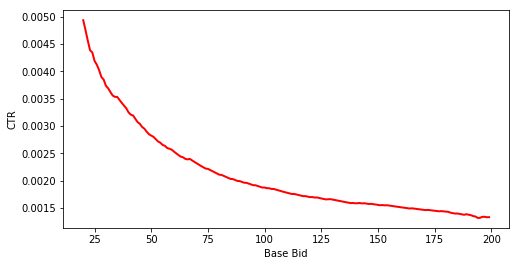

In [46]:
import matplotlib.pyplot as plt

plot_x = df_logs['basebid']
plot_y = df_logs['ctr']
plt.figure(figsize=(8,4)) 
plt.xlabel("Base Bid")  
plt.ylabel("CTR")
plt.plot(plot_x, plot_y,color="red",linewidth=2)
plt.show()

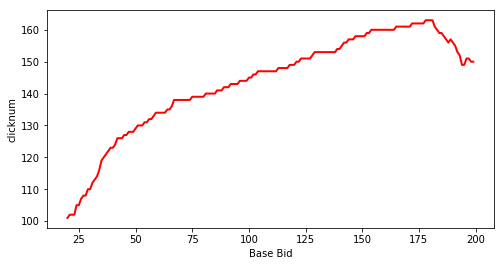

In [48]:
import matplotlib.pyplot as plt

plot_x = df_logs['basebid']
plot_y = df_logs['clicks']
plt.figure(figsize=(8,4)) 
plt.xlabel("Base Bid")  
plt.ylabel("clicknum")
plt.plot(plot_x, plot_y,color="red",linewidth=2)
plt.show()

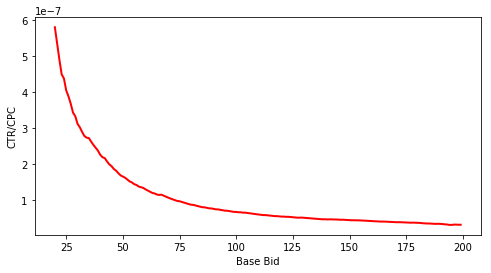

In [49]:
import matplotlib.pyplot as plt

plot_x = df_logs['basebid']
plot_y = df_logs['ctr']/df_logs['cpc']
plt.figure(figsize=(8,4)) 
plt.xlabel("Base Bid")  
plt.ylabel("CTR/CPC")
plt.plot(plot_x, plot_y,color="red",linewidth=2)
plt.show()

### apply the model to test set:

In [10]:
p_test = fm.predict(X_test_FM)
Cali_test = Cali_CTR(p_test, 0.0075)
Y_test = np.array(Y_test)
#Bid_id = Y_test[:,0]

In [11]:
Cali_test

array([ 0.00114782,  0.0132081 ,  0.00489424, ...,  0.00509052,
        0.0051516 ,  0.00622875])

In [28]:
len(p_test)

303375

In [24]:
len(Cali_test)

303375

In [27]:
pickle.dump(p_test, open("p_test_fm.pickle.dat", "wb"))

In [25]:
pickle.dump(Cali_test, open("cali_test_fm.pickle.dat", "wb"))

In [ ]:
bidprice_test = pbidprice(Cali_test, base)

In [ ]:
#use single model to test data
base = 0
bidp_test = []
win_number_test = []
totalcost_test = []
clicknum_test = []
ctr_p_test = []
cpc_p_test = []
for i in range(200):
    bid_p = pbidprice(Cali_test, base)
    win_num, total_cost, click_num, ctr, cpc = evaluation(bid_p, payprice_val, clicks_val)
    print(base)
#     win_number_test.append(win_num)
#     totalcost_test.append(total_cost)
#     clicknum_test.append(click_num)
#     ctr_p_test.append(ctr)
#     cpc_p_test.append(cpc)
#     bidp_test.append(bid_p)
    base += 1

# Model Stacking

In [117]:
w_rf = 0.25
w_fm = 1
w_nn = 0.125
w_ad = 0.125

In [118]:
x_train_stack = np.concatenate(
                (np.log1p(w_rf*Cali_rf.reshape(-1, 1)), 
                 np.log1p(w_fm*Cali_fm.reshape(-1, 1)), 
                 np.log1p(w_nn*Cali_nn.reshape(-1, 1)),
                 np.log1p(w_ad*Cali_ada.reshape(-1,1))), axis=1)

/Users/liuce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


In [119]:
x_train_stack = np.array([np.array(x, dtype=np.int32) for x in x_train_stack])

In [120]:
x_train_stack

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ..., 
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [121]:
from sklearn.linear_model import LinearRegression
stack_model = LinearRegression().fit(x_train_stack, target_val)
stack_model.fit(x_train_stack, target_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [122]:
Cali_stack = stack_model.predict(x_train_stack)

In [123]:
fpr, tpr, thresholds = metrics.roc_curve(target_val, Cali_stack, pos_label=1)
auc = metrics.auc(fpr, tpr)

print('auc on test: ', auc)
print ("RMSE on test dataset = %.2f" % (rmse(target_val, Cali_stack)))

auc on test:  0.500003292474
RMSE on test dataset = 0.03


# 训练payprice

In [23]:
X_FM.shape

(20012, 34261)

In [164]:
pred_fm_train

array([[ 0.03131623],
       [ 0.00924577],
       [ 0.00175292],
       ..., 
       [ 0.04050119],
       [ 0.00840081],
       [ 0.01648946]])